In [77]:
from pyspark.sql import SQLContext

In [78]:
# Joe needs this
if not 'sc' in globals():
    from pyspark import SparkContext
    sc = SparkContext()

In [79]:
sc_sql = SQLContext(sc)
df = sc_sql.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load("data.csv")
df.printSchema()

root
 |-- action_type: string (nullable = true)
 |-- combined_shot_type: string (nullable = true)
 |-- game_event_id: integer (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- loc_x: integer (nullable = true)
 |-- loc_y: integer (nullable = true)
 |-- lon: double (nullable = true)
 |-- minutes_remaining: integer (nullable = true)
 |-- period: integer (nullable = true)
 |-- playoffs: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- seconds_remaining: integer (nullable = true)
 |-- shot_distance: integer (nullable = true)
 |-- shot_made_flag: integer (nullable = true)
 |-- shot_type: string (nullable = true)
 |-- shot_zone_area: string (nullable = true)
 |-- shot_zone_basic: string (nullable = true)
 |-- shot_zone_range: string (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- team_name: string (nullable = true)
 |-- game_date: timestamp (nullable = true)
 |-- matchup: string (nullable = true)
 |-- opponent:

In [80]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import datediff, to_date, lit, min
df = df.withColumn("season_num", df.season[0:4].cast(IntegerType())-1996)
df = df.withColumn("home_game", df.matchup.contains("@").cast(IntegerType()))
df = df.withColumn("time_remaining", df.minutes_remaining*60+df.seconds_remaining)

min_date = df.agg(min(df.game_date)).collect()[0][0]
df = df.withColumn("days_since_start", datediff(df.game_date, lit(min_date)))

df = df.withColumnRenamed("shot_made_flag", "label")

In [81]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer
from pyspark.ml import Pipeline
all_categorical_columns = ['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent']
stages = []

for cat_col in all_categorical_columns:
    stringIndexer = StringIndexer(inputCol = cat_col, outputCol = cat_col + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[cat_col + "classVec"])
    stages += [stringIndexer, encoder]

common_pipeline = Pipeline(stages = stages)
common_pipeline_model = common_pipeline.fit(df)
df = common_pipeline_model.transform(df)
#selectedCols = ['features'] + df.columns
#df = df.select(selectedCols)
df.printSchema()

root
 |-- action_type: string (nullable = true)
 |-- combined_shot_type: string (nullable = true)
 |-- game_event_id: integer (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- loc_x: integer (nullable = true)
 |-- loc_y: integer (nullable = true)
 |-- lon: double (nullable = true)
 |-- minutes_remaining: integer (nullable = true)
 |-- period: integer (nullable = true)
 |-- playoffs: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- seconds_remaining: integer (nullable = true)
 |-- shot_distance: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- shot_type: string (nullable = true)
 |-- shot_zone_area: string (nullable = true)
 |-- shot_zone_basic: string (nullable = true)
 |-- shot_zone_range: string (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- team_name: string (nullable = true)
 |-- game_date: timestamp (nullable = true)
 |-- matchup: string (nullable = true)
 |-- opponent: string (

In [84]:
kaggle_test = df.filter(df.label.isNull())
df = df.dropna()
train, test = df.randomSplit([0.8, 0.2], seed = 1)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 20520
Test Dataset Count: 5177


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from sklearn.metrics import roc_curve, auc

def show_roc_curve(fpr, tpr, roc_auc):
    import matplotlib
    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.8f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_predictions(y_true, y_pred, y_prob = []):
#     total = labelPreds.count()
#     true_pos = labelPreds.filter((labelPreds.shot_made_flag == 1) & (labelPreds.prediction == 1)).count()
#     false_pos = labelPreds.filter((labelPreds.shot_made_flag == 0) & (labelPreds.prediction == 1)).count()
#     false_neg= labelPreds.filter((labelPreds.shot_made_flag == 1) & (labelPreds.prediction == 0)).count()
#     true_neg = labelPreds.filter((labelPreds.shot_made_flag == 0) & (labelPreds.prediction == 0)).count()
    total = len(y_true)
    print("Total: " + str(total))
    print("Precision: " + str(precision_score(y_true, y_pred)))
    print("Recall: " + str(recall_score(y_true, y_pred)))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    if len(y_prob) != 0:
        print("Log loss: " + str(log_loss(y_true, y_prob)))
    
    fpr, tpr, thresholds = roc_curve(y_true, [y[1] for y in y_prob], pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print("Area under ROC curve: " + str(roc_auc))
    show_roc_curve(fpr, tpr, roc_auc)

In [57]:
from pyspark.ml.evaluation import Evaluator
from sklearn.metrics import log_loss

class LogLossEvaluator(Evaluator):

    def __init__(self, probabilityCol="probability", labelCol="label"):
        self.probabilityCol = probabilityCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        y_true = np.array(predictions.select(self.labelCol).collect()).reshape(-1)
        y_prob = np.array(predictions.select(self.probabilityCol).collect()).reshape(-1, 2)
        return log_loss(y_true, y_prob)

    def isLargerBetter(self):
        return False

# Logistic Regression

Training Dataset Count: 20520
Test Dataset Count: 5177
Time to train model: 88.149 seconds
{Param(parent='LogisticRegression_a374cf70a969', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_a374cf70a969', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0, Param(parent='LogisticRegression_a374cf70a969', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto', Param(parent='LogisticRegression_a374cf70a969', name='featuresCol', doc='features column name'): 'features', Param(parent='LogisticRegression_a374cf70a969', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LogisticRegression_a374cf70a969', name='labelCol', doc='label column name'): 'label', Param(parent='LogisticR

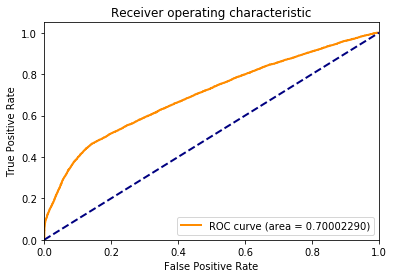

Testing Data:
Total: 5177
Precision: 0.7162698412698413
Recall: 0.4735461303017053
Accuracy: 0.6845663511686305
Log loss: 0.6229860374563932
Area under ROC curve: 0.69297064951138


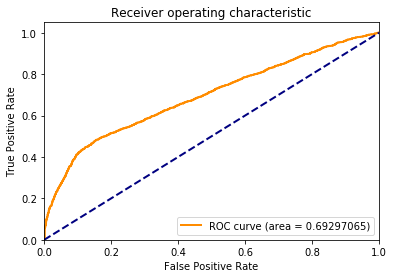

In [115]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
import numpy as np
%matplotlib inline
from time import *

start_time = time()

numeric_columns = ['loc_x', 'loc_y', 'period', 'playoffs', 'shot_distance', 'season_num', 'home_game', 'time_remaining', 'days_since_start']
categorical_columns = ['action_type', 'shot_zone_area', 'shot_zone_basic', 'opponent', 'shot_type']
# Convert categorical to Onehot
assemblerInputs = [c + "classVec" for c in categorical_columns] + numeric_columns
# Convert categorical to ordinal
#assemblerInputs = [c + "Index" for c in categorical_columns] + numeric_columns
# Don't convert categorical
# assemblerInputs = categorical_columns + numeric_columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
lr_pipeline = Pipeline(stages=[assembler, scaler])
lr_pipeline_model = lr_pipeline.fit(df)
lr_df = lr_pipeline_model.transform(df)

lr_df = lr_df.dropna()
lr_train, lr_test = lr_df.randomSplit([0.8, 0.2], seed = 1)
print("Training Dataset Count: " + str(lr_train.count()))
print("Test Dataset Count: " + str(lr_test.count()))

lr = LogisticRegression(featuresCol="features")
#lr = LogisticRegression(featuresCol="scaled_features")

#              .addGrid(lr.regParam, [0, 0.001, 0.01, 0.1, 1, 10, 100]) \
#              .addGrid(lr.maxIter, [10, 100, 1000]) \
#              .addGrid(lr.aggregationDepth, [2, 5, 10]) \
#              .addGrid(lr.fitIntercept, [True, False]) \
#              .addGrid(lr.elasticNetParam, [0, 0.5, 1]) \
param_grid = ParamGridBuilder()\
             .build()
cross_validator = CrossValidator(estimator=lr,
                                 estimatorParamMaps=param_grid,
                                 evaluator=LogLossEvaluator(),
                                 parallelism=6,
                                 seed=12345,
                                 numFolds=5)
cross_validator_model = cross_validator.fit(lr_train)

end_time = time()
print("Time to train model: %.3f seconds" % (end_time-start_time))
print(cross_validator_model.bestModel.extractParamMap())

print("Training Data:")
predictions = cross_validator_model.transform(lr_train)
y_true = np.array(predictions.select("label").collect()).reshape(-1)
y_pred = np.array(predictions.select("prediction").collect()).reshape(-1)
y_prob = np.array(predictions.select("probability").collect()).reshape(-1, 2)
evaluate_predictions(y_true, y_pred, y_prob)

print("Testing Data:")
predictions = cross_validator_model.transform(lr_test)
y_true = np.array(predictions.select("label").collect()).reshape(-1)
y_pred = np.array(predictions.select("prediction").collect()).reshape(-1)
y_prob = np.array(predictions.select("probability").collect()).reshape(-1, 2)
evaluate_predictions(y_true, y_pred, y_prob)


In [113]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
lr_pipeline_model = lr_pipeline.fit(kaggle_test)
kaggle_test_df = lr_pipeline_model.transform(kaggle_test)

second_udf = udf(lambda value: value[1].item(), FloatType())
kaggle_test_df = cross_validator_model.bestModel.transform(kaggle_test_df)
#output_df = kaggle_test_df.select("shot_id", "probability").withColumn("probability2", second_udf(kaggle_test_df.probability))
#output_df.toPandas()
output_df = kaggle_test_df.toPandas()[["shot_id", "probability"]]
output_df["shot_made_flag"] = output_df["probability"].apply(lambda x: x[1])
output_df = output_df[["shot_id", "shot_made_flag"]]
output_df.to_csv("kaggle.csv", index=False)